[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yhtang/FunFact/blob/master/docs/examples/quantum-compilation.ipynb)

# Optimizing a quantum circuit with FunFact

## Install package and obtain assets if running on Google Colab

In [1]:
try:
    import google.colab
    !pip install funfact
except:
    pass

## Introduction

In this tutorial we use FunFact to formulate a tensor expression that we use to optimize the parameters of a [**quantum circuit**](https://en.wikipedia.org/wiki/Quantum_circuit). Quantum circuits form a model for quantum computation in which the computation is represented by a sequence of simpler [**quantum gates**](https://en.wikipedia.org/wiki/Quantum_logic_gate) acting on the individual qubits in the system, typically just one or two qubits. As the overall evolution of a closed quantum system is unitary, both the circuit and the individual gates are unitary operators. The individual gates are combined along *the space dimension* by Kronecker products and *in time dimension* by matrix inner products. This property of the circuit model allows us to write a quantum circuit as a FunFact tensor expression with unitary penalties on the leaf tensors.

This problem is also known as the **quantum circuit synthesis** or **quantum compilation** problem and we will explore the use of FunFact for solving it. We'll be using the `PyTorch` backend.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import funfact as ff
from funfact.initializers import Normal
from funfact.loss import MSE
from funfact import active_backend as ab

In [3]:
ff.use('torch')
ab

<backend 'PyTorchBackend'>

In [4]:
ab.set_printoptions(precision=3, sci_mode=False, linewidth=320)

## Target data

The matrix that we will optimize a circuit structure for is the 3 qubit ($2^3 \times 2^3$) DFT matrix. We start by generating the target matrix in `PyTorch` data format:

In [5]:
n = 3
QFT_matrix = ab.tensor(np.matrix(np.fft.fft(np.eye(2**n)) / np.sqrt(2**n)))
QFT_matrix

tensor([[ 0.354+0.000j,  0.354+0.000j,  0.354+0.000j,  0.354+0.000j,  0.354+0.000j,  0.354+0.000j,  0.354+0.000j,  0.354+0.000j],
        [ 0.354+0.000j,  0.250-0.250j,  0.000-0.354j, -0.250-0.250j, -0.354+0.000j, -0.250+0.250j,  0.000+0.354j,  0.250+0.250j],
        [ 0.354+0.000j,  0.000-0.354j, -0.354+0.000j,  0.000+0.354j,  0.354+0.000j,  0.000-0.354j, -0.354+0.000j,  0.000+0.354j],
        [ 0.354+0.000j, -0.250-0.250j,  0.000+0.354j,  0.250-0.250j, -0.354+0.000j,  0.250+0.250j,  0.000-0.354j, -0.250+0.250j],
        [ 0.354+0.000j, -0.354+0.000j,  0.354+0.000j, -0.354+0.000j,  0.354+0.000j, -0.354+0.000j,  0.354+0.000j, -0.354+0.000j],
        [ 0.354+0.000j, -0.250+0.250j,  0.000-0.354j,  0.250+0.250j, -0.354+0.000j,  0.250-0.250j,  0.000+0.354j, -0.250-0.250j],
        [ 0.354+0.000j,  0.000+0.354j, -0.354+0.000j,  0.000-0.354j,  0.354+0.000j,  0.000+0.354j, -0.354+0.000j,  0.000-0.354j],
        [ 0.354+0.000j,  0.250+0.250j,  0.000+0.354j, -0.250+0.250j, -0.354+0.000j, -0.250

It is well-known that the unitary DFT matrix can be decomposed in a quantum circuit with $\mathcal{O}(n^2)$ one- and two-qubit gates. This implementation is also known as the [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform) (QFT). The theoretical circuit structure is as follows:

![qft3](../qft_circuit.png)

This circuit consists of:

* Hadamard gates:

$$H = \frac{1}{\sqrt{2}}\begin{bmatrix}1 & 1\\ 1 & -1\end{bmatrix},$$

* (Controlled) phase gates:

$$P(\theta) = \begin{bmatrix}1 & \\ & e^{i \theta}\end{bmatrix},$$

* SWAP gates.

A particular challenge that can prohibit runnig this circuit on quantum hardware is that the controlled phase gates and SWAP gates require an all-to-all connectivity between the qubits of the quantum computer. This connectivity is often available due to hardware constraints. Our goal is to recompile the `QFT_matrix` unitary into a circuit that can be implemented on a quantum device with *linear connectivity* between the qubits. To this end we define a function that generates a tensor expression for a two-qubit gate.

## Quantum gates as tensor expressions

As an initializer for our two-qubit gates, we use the standard normal distribution. The unitary penalty is enforced by a unitary condition that is *summed* over the matrix elements of the leafs:

In [6]:
init = ff.initializers.Normal(std=1.0, dtype=ab.complex64)
unitary_cond = ff.conditions.Unitary(reduction='sum')

Next, we define a tensor expression for a two qubit gate acting on consecutive qubits $i, i+1$ of an $n$ qubit system.

In [7]:
def two_qubit_gate(i: int, n: int):
    ''' Generate a tensor expression that implements a two-qubit
    quantum gate acting on qubits i, i+1.
    
    Args:
        i (int): index of first qubit of two-qubit gate,
                 between 0 and n-2.
        n (int): total number of qubits.
    Returns:
        tsrex: tensor expression representing a two-qubit
        gate acting on qubits i, i+1 of an n-qubit system.

            ---
       i --|   |--
           | U |
     i+1 --|   |--
            ---

    '''
    G = ff.tensor(4, 4, initializer=init, prefer=unitary_cond)
    if i > 0 and i < n-2:
        tsrex = ff.eye(2**i) & G & ff.eye(2**(n-i-2))
    elif i == 0:
        tsrex = G & ff.eye(2**(n-2))
    elif i == n-2:
        tsrex = ff.eye(2**(n-2)) & G
    else:
        raise IndexError(f'Index i needs to satisfy: 0 <= i < {n-1}, got i={i}.')   
    return tsrex

A two-qubit gate is thus represented as a Kronecker product of an (optimizibable) $4 \times 4$ matrix with unitary penalty and identity matrices that scale it up to an n-qubit matrix:

In [8]:
two_qubit_gate(1,4)

## Quantum circuits from gates

Next, we generate the tensor expression for the complete circuit as a product of 3 two-qubit gates that are placed in a staggered pattern:

![nearest-neighbor](../nn_circuit.png)

As time flows from left to right in a quantum circuit, the order in which the gates appears in a sequence of matrix multiplications is reversed compared to the circuit diagram:

In [9]:
circuit = two_qubit_gate(0, 3) @ \
          two_qubit_gate(1, 3) @ \
          two_qubit_gate(0, 3)

The loss function is the MSE-L2 loss, summed over the matrix elements:

In [10]:
MSE_loss = MSE('sum')

Next, we use the `factorize` method to opitimze the `circuit` tensor expression for the `QFT_matrix` unitary matrix:

In [11]:
circuit_fac = ff.factorize(
    circuit, QFT_matrix,
    max_steps=1000,
    tol=1e-3,
    lr=7e-2,
    vec_size=32,
    loss=MSE_loss,
    dtype=ab.complex64,
    checkpoint_freq=40,
    penalty_weight=2.0
)

 28%|██▊       | 280/1000 [00:02<00:07, 97.39it/s] 


The loss and total penalty on the `circuit_fac` factorization is:

In [12]:
print(f'loss: {MSE_loss(circuit_fac(), QFT_matrix)}')
print(f'penalty: {circuit_fac.penalty(sum_leafs=True)}')

loss: 0.00010626781269008971
penalty: 2.0135496470174985e-06


The penalties on the 6 individual leaf tensors are:

In [13]:
print(f'penalties: {circuit_fac.penalty(sum_leafs=False)}')

penalties: tensor([    0.000,     0.000,     0.000])


A visual representation of the magnitude and phases of the QFT matrix and the optimized circuit model are shown below:

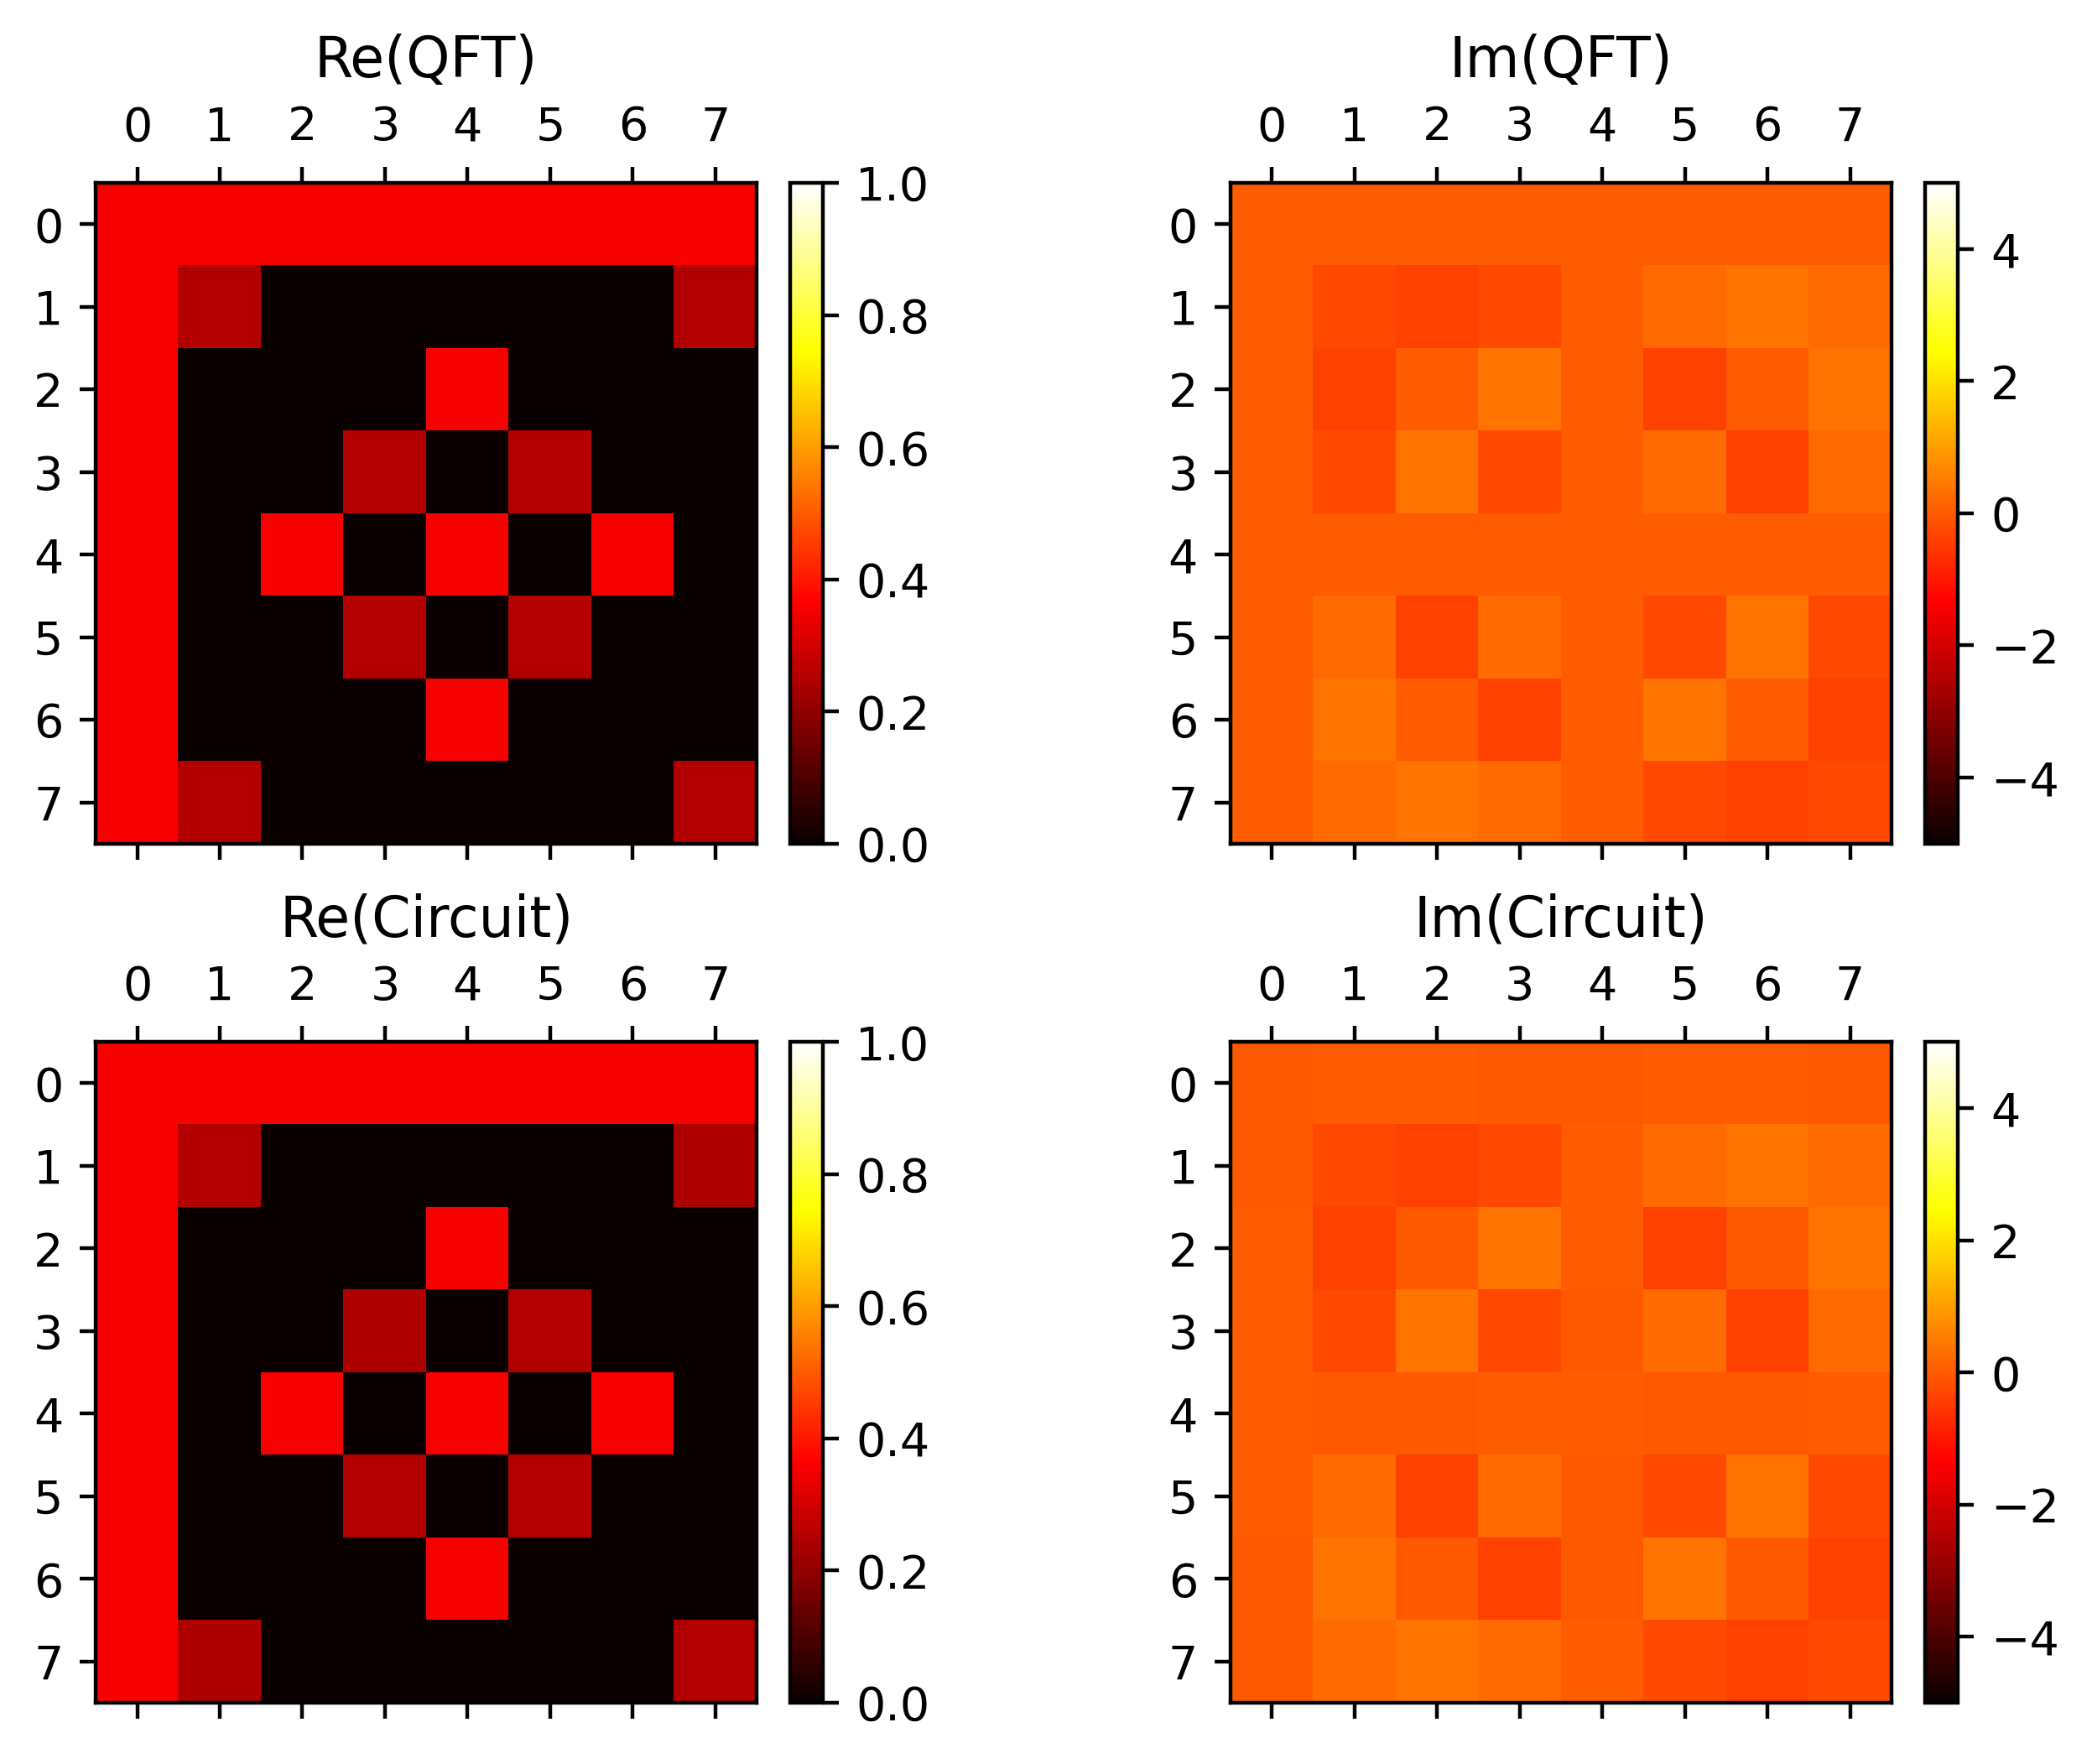

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8,6), dpi=200)
plt.subplots_adjust(hspace=0.3)

for ax, title, mat, vrange in [
    (axs[0, 0], 'Re(QFT)', ab.real(QFT_matrix), (0, 1)),
    (axs[0, 1], 'Im(QFT)', ab.imag(QFT_matrix), (-5, 5)),
    (axs[1, 0], 'Re(Circuit)', ab.real(circuit_fac()), (0, 1)),
    (axs[1, 1], 'Im(Circuit)', ab.imag(circuit_fac()), (-5, 5)),
]:
    ax.set_title(title)
    im = ax.matshow(mat, vmin=vrange[0], vmax=vrange[1], cmap='hot')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

plt.show()

The unitarniness of the leaf tensors is visualized by plotting $|U^{(i)\dagger} U^{(i)}|$:

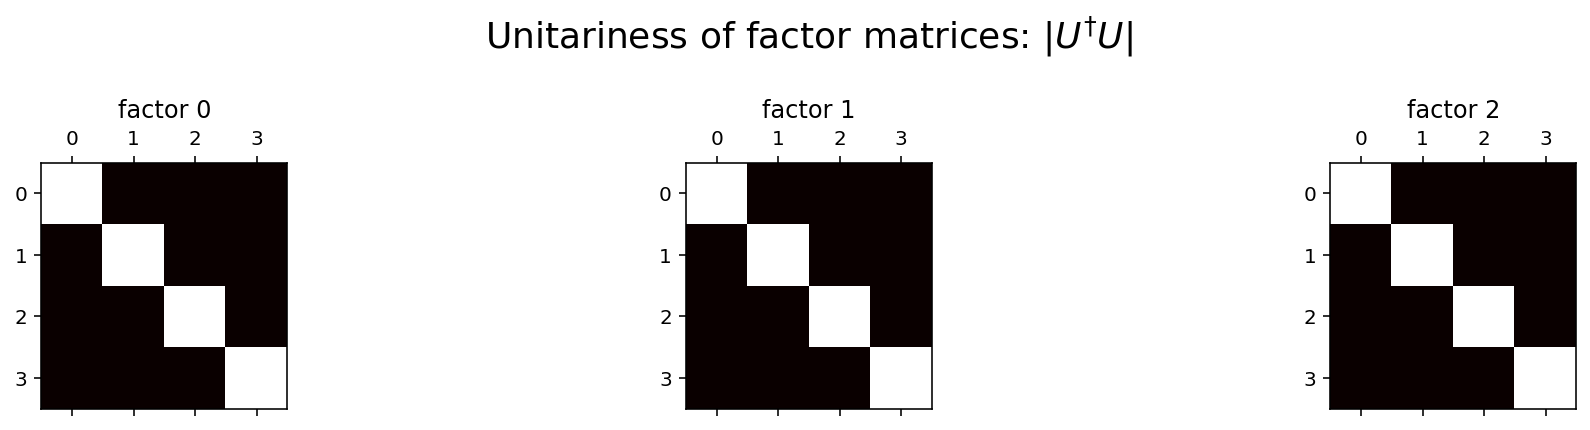

In [15]:
fig, axs = plt.subplots(1, len(circuit_fac.factors), 
                        figsize=(15, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i, f in enumerate(circuit_fac.factors):
    data = ab.matmul(f, ab.conj(ab.transpose(f, (1, 0))))
    axs[i].matshow(ab.abs(data),vmin=0, vmax=1.0, cmap='hot')
    axs[i].set_title(f'factor {i}')
fig.suptitle('Unitariness of factor matrices: $|U^{\dagger}U|$', fontsize=18)
fig.tight_layout() 
plt.show()

These $4 \times 4$ leaf tensors can be directly synthesized into native gates by means of direct methods such as the [KAK decomposition](https://en.wikipedia.org/wiki/Cartan_decomposition).